In [1]:
%load_ext autoreload
%autoreload 2
import pygrib
import numpy as np

## Weather cube generator

### 2d grid generator

In [179]:
def rotate_coord(old_coord, theta):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    new_coord = np.transpose(rotation_matrix, (2,0,1)).dot(old_coord)
    return new_coord
    
def create_grid(center_x, center_y, shift_xleft, shift_xright, shift_yup, shift_ydown, nx, ny, theta):
    # x, y is in the unit of degrees
    x = np.linspace(0 - shift_xleft, 0 + shift_xright, nx)
    y = np.linspace(0 - shift_ydown, 0 + shift_yup, ny)
    xv, yv = np.meshgrid(x, y, sparse = False)
    grid_2d = np.vstack((xv.flatten(),yv.flatten()))
    rotate_grid = rotate_coord(grid_2d, theta).T + np.array([[center_x, center_y]])
    # [Lon, Lat]
    return rotate_grid

In [180]:
rotate_grid = create_grid(center_x = np.array([-95, -96, -97]), 
                        center_y = np.array([30, 31, 32]), 
                        shift_xleft = 0, 
                        shift_xright = 2, 
                        shift_yup = 1, 
                        shift_ydown = 1, 
                        nx = 10, 
                        ny = 10, 
                        theta = np.array([np.pi/4, np.pi/3, np.pi/2]))

In [182]:
rotate_grid.shape

(100, 2, 3)

In [48]:
cartesian_grid = create_grid(center_x = -95, 
                        center_y = 30, 
                        shift_xleft = 0, 
                        shift_xright = 2, 
                        shift_yup = 1, 
                        shift_ydown = 1, 
                        nx = 10, 
                        ny = 10,
                        theta = 0)

In [45]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

/home/liuyulin/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/liuyulin/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


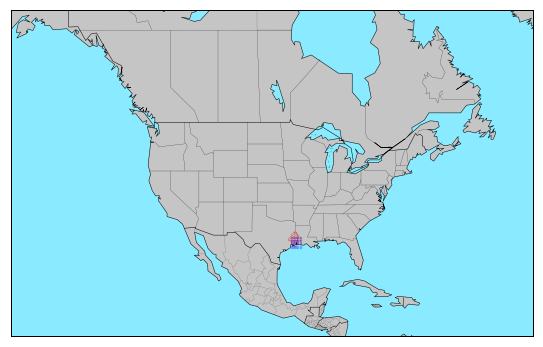

In [49]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon = -153,llcrnrlat = 12.,urcrnrlon = -45,urcrnrlat = 62,projection='merc')
m.drawmapboundary(fill_color='#8aeaff')
m.fillcontinents(color='#c5c5c5', lake_color='#8aeaff')
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.1)

x, y = m(rotate_grid[:, 0], rotate_grid[:, 1])
x_ca, y_ca = m(cartesian_grid[:, 0], cartesian_grid[:, 1])

plt.plot(x, y, 'ro',ms = 0.1)
plt.plot(x_ca, y_ca, 'bo',ms = 0.1)

### data cube generator

In [50]:
test_wind_npz = np.load('../../DATA/filtered_weather_data/namanl_small_npz/namanl_218_20130101_0000_000.npz')

In [54]:
grbs_common_info = np.load('/media/storage/DATA/filtered_weather_data/grbs_common_info.npz')
basegrid_lat = grbs_common_info['basegrid_lat']
basegrid_lon = grbs_common_info['basegrid_lon']
basegrid = grbs_common_info['basegrid']
smallgrid = grbs_common_info['smallgrid']
small_idx = grbs_common_info['small_idx']
lvls = grbs_common_info['levels']
lvls_dict = {}
i = 0
for lvl in lvls:
    lvls_dict[lvl] = i
    i += 1

In [66]:
with open('/media/storage/DATA/filtered_weather_data/grbs_level_common_info.pkl', 'rb') as pfile:
    lvls_dict = pickle.load(pfile)
with open('/media/storage/DATA/filtered_weather_data/grbs_smallgrid_kdtree.pkl', 'rb') as pfile:
    smallgrid_tree = pickle.load(pfile)

In [93]:
wx_pointer = np.load('../../DATA/NCWF/gridded_storm.npz')
ncwf_arr = wx_pointer['ncwf_arr']
start_time = wx_pointer['start_time']
unique_alt = wx_pointer['unique_alt']
with open('../../DATA/NCWF/alt_dict.pkl', 'rb') as pfile:
    alt_dict = pickle.load(pfile)

In [166]:
def generate_feature_cube(lat, 
                           lon,
                           alt, # in 1000 feet; FL//10
                           lvl, 
                           TODO_TIME,
                           azimuth,
                           uwind_arr,
                           vwind_arr,
                           tempr_arr,
                           ncwf_wx_arr, 
                           grid_tree,
                           wind_lvls_dict,
                           wx_alt_dict,
                           wx_unique_alt, 
                           wx_alt_buffer = 10, # in 1000 feet
                           **kwargs):

    shift_xleft = kwargs.get('shift_xleft', 0)
    shift_xright = kwargs.get('shift_xright', 2)
    shift_yup = kwargs.get('shift_yup', 1)
    shift_ydown = kwargs.get('shift_ydown', 1)
    nx = kwargs.get('nx', 20)
    ny = kwargs.get('ny', 20)
    
    grid_cube = create_grid(center_x = lon, 
                            center_y = lat, 
                            shift_xleft = shift_xleft, 
                            shift_xright = shift_xright, 
                            shift_yup = shift_yup, 
                            shift_ydown = shift_ydown, 
                            nx = nx, 
                            ny = ny,
                            theta = azimuth)
    _, query_idx = grid_tree.query(grid_cube)
    uwind_base = uwind_arr[lvls_dict[lvl]][query_idx]
    vwind_base = vwind_arr[lvls_dict[lvl]][query_idx]
    tempr_base = tempr_arr[lvls_dict[lvl]][query_idx]
    
    wx_alt_cover = wx_unique_alt[(wx_unique_alt >= (alt - wx_alt_buffer)) & (wx_unique_alt <= (alt + wx_alt_buffer))]
    wx_alt_idxmin = wx_alt_dict[wx_alt_cover.min()]
    wx_alt_idxmax = wx_alt_dict[wx_alt_cover.max()]
    wx_base = np.any(ncwf_wx_arr[TODO_TIME, wx_alt_idxmin: wx_alt_idxmax + 1, :][:, query_idx], axis = 0).astype(np.int8).reshape(20, 20)
    
    
    feature_cube = np.dstack((uwind_base.reshape(nx,ny), 
                              vwind_base.reshape(nx,ny), 
                              tempr_base.reshape(nx,ny)))
    return feature_cube, wx_base, query_idx

In [164]:
import time

In [170]:
uwind_arr = test_wind_npz['uwind']
vwind_arr = test_wind_npz['vwind']
tempr_arr = test_wind_npz['tempr']

In [172]:
st = time.time()
test_feature_cube, wx_layer, query_idx = generate_feature_cube(lat = 30, 
                           lon = -95,
                           alt = 33, # in 1000 feet; FL//10
                           lvl = 200, 
                          TODO_TIME = 0,
                           azimuth = np.pi/4,
                           uwind_arr = uwind_arr,
                            vwind_arr = vwind_arr,
                            tempr_arr = tempr_arr,
                           ncwf_wx_arr = ncwf_arr, 
                           grid_tree = smallgrid_tree,
                           wind_lvls_dict = lvls_dict,
                           wx_alt_dict = alt_dict,
                           wx_unique_alt = unique_alt, 
                           wx_alt_buffer = 10) # in 1000 feet
print(time.time() - st)

0.001969575881958008


In [130]:
wx_layer

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [129]:
test_feature_cube[:, :, 2]

array([[215.62561, 215.62561, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.50061, 215.62561, 215.62561, 215.62561,
        215.62561, 215.75061],
       [215.50061, 215.50061, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.62561, 215.62561, 215.62561, 215.62561,
        215.62561, 215.75061],
       [215.50061, 215.50061, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.50061, 215.62561, 215.62561, 215.62561,
        215.62561, 215.62561],
       [215.50061, 215.50061, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.50061, 215.50061, 215.50061, 215.50061,
        215.50061, 215.50061, 215.50061, 215.50061, 215.62561, 215.50061,
        215.62561, 

In [48]:
st = time.time()
grbs = pygrib.open('../../filtered_weather_data/namanl/namanl_218_20130104_0000_003.grb')
uin = grbs.select(shortName='u', typeOfLevel='isobaricInhPa', level = lambda l: l >= 150 and l <= 1000)
vin = grbs.select(shortName='v', typeOfLevel='isobaricInhPa', level = lambda l: l >= 150 and l <= 1000)
# testU = grbs.select(shortName='v', typeOfLevel='pressureFromGroundLayer')
# for i in range(grbs.messages):
#     print(grbs.message(i+1))
grbs.close()
winds = [(uin, vin)]
print(time.time() - st)

0.6161456108093262


In [3]:
a = winds[0][0][0].data()

In [12]:
np.save('test.npy', a)

## Test load from zip

In [14]:
import zipfile
import io
import time
import os
import shutil

In [16]:
zwind = zipfile.ZipFile('../../DATA/filtered_weather_data/namanl/namanl.zip', mode = 'r')
namelist = zwind.namelist()

In [17]:
len(namelist)

7133

In [64]:
tmp = io.BytesIO(zwind.open(name = namelist[1]).read())
tmp2 = io.StringIO(namelist[1])

tmp_bytes = zwind.open(name = namelist[1]).read()

In [ ]:
grbs = pygrib.open('../../filtered_weather_data/namanl/namanl.zip/')

In [16]:
len(tmp_bytes)

31347210

In [60]:
st = time.time()
zwind.extract(member=namelist[50], path='../weather/namanl')
shutil.rmtree(path = '../weather/namanl/')
print(time.time() - st)

0.291705846786499


In [ ]:
zwind.close()